In [1]:
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt
from mnist import MNIST
from utils import show_image
from sklearn import metrics

# 1 - Lendo o dataset

In [2]:
mnist = MNIST('datasets/mnist')
train_images, train_labels = mnist.load_training()
test_images, test_labels = mnist.load_testing()

shape = (28,28)

# 2 - Criando variaveis de pesos e bias

In [3]:
input_size = shape[0]*shape[1]

layers_size = [
    120,
    80
]

conv_out = [
    20,
    50
]

conv_shape = (5,5)

out_conv_step_size = ((shape[0]/4)**2)*conv_out[-1]


output_size = 10

w = {
    'c1':tf.Variable(tf.random_normal(
        [conv_shape[0],conv_shape[1],1,conv_out[0]])),
    'c2':tf.Variable(tf.random_normal(
        [conv_shape[0],conv_shape[1],conv_out[0],conv_out[1]])),
    'w1':tf.Variable(tf.random_normal(
        [out_conv_step_size, layers_size[0]])),
    'w2':tf.Variable(tf.random_normal([layers_size[0], layers_size[1]])),
    'wo':tf.Variable(tf.random_normal([layers_size[1], output_size])),

}

b = {
    'b1': tf.Variable(tf.random_normal([layers_size[0]])),
    'b2': tf.Variable(tf.random_normal([layers_size[1]])),
    'bo': tf.Variable(tf.random_normal([output_size])),

}

# 3 - Função da Rede

In [4]:
def cnn(input_x):
    reshaped_x = tf.reshape(input_x, shape=[-1,shape[0],shape[1],1])    
    conv1 = tf.nn.conv2d(reshaped_x,w['c1'],strides=[1,1,1,1], padding='SAME')
    act_conv1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(act_conv1,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    conv2 = tf.nn.conv2d(pool1,w['c2'],strides=[1,1,1,1], padding='SAME')
    act_conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.avg_pool(act_conv2,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    reshaped_x_vecctor = tf.reshape(pool2, shape=[-1,out_conv_step_size])    

    h1 = tf.nn.tanh(tf.add(tf.matmul(reshaped_x_vecctor,w['w1']),b['b1']))
    h2 = tf.nn.tanh(tf.add(tf.matmul(h1,w['w2']),b['b2']))
    
    out = tf.nn.softmax(tf.add(tf.matmul(h2,w['wo']),b['bo']))
    
    return out

# 3.1 - Exemplo

In [5]:
input_x = tf.placeholder(dtype=tf.float32, shape=(2,input_size))
r = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out = cnn(input_x)
    r = sess.run(out, feed_dict={input_x: train_images[:2]})
r

array([[9.5647192e-05, 1.4496477e-07, 2.4677853e-05, 9.9982125e-01,
        9.5121997e-08, 4.8572474e-05, 7.2942476e-07, 8.1705612e-06,
        7.4268934e-07, 5.1998401e-09],
       [2.6246703e-11, 1.1615427e-03, 9.6721184e-01, 2.1040199e-11,
        1.0322796e-02, 1.4012944e-02, 3.5978025e-03, 5.3846038e-06,
        3.6854586e-03, 2.1554617e-06]], dtype=float32)

# 4 - Ajustando labels

In [7]:
np_test_images = np.matrix(test_images, dtype=np.float32)

np_train_labels = np.zeros((len(train_labels),10), dtype=np.float32)
for i in range(len(train_labels)):
    np_train_labels[i,train_labels[i]]=1

np_test_labels = np.zeros((len(test_labels),10), dtype=np.int)
for i in range(len(test_labels)):
    np_test_labels[i,test_labels[i]]=1

# 5 - Criando os Placeholders para input e Variáveis auxiliares

In [8]:
n_batchs = 20

total_size = len(train_labels)
batch_size = int(total_size/n_batchs)


init = tf.global_variables_initializer()
train_x = tf.placeholder(shape=(batch_size,input_size),dtype=tf.float32, name='input_x')
train_y = tf.placeholder(shape=(batch_size,output_size),dtype=tf.int32, name='input_y')

test_x = tf.constant(np_test_images,name='test_x')
test_y = tf.constant(test_labels.tolist(), dtype=tf.int64 ,name='test_y')

predict_train = cnn(train_x)
predict_test = tf.math.argmax(cnn(test_x), axis=1)

# 5.1 - Variaveis auxiliares para etapa de otimização

In [9]:
loss_op = tf.losses.mean_squared_error(train_y,predict_train)

adam = tf.train.AdamOptimizer(learning_rate=0.0001)
adam_optimization = adam.minimize(
                loss_op,
                var_list = w.values()+b.values()
            )

In [10]:
loss_vector = []
acc_vector = []

acc_op = tf.contrib.metrics.accuracy(
    predict_test,
    test_y
)

# 5.2 - Saver para salvar o modelo

In [11]:
saver = tf.train.Saver()

# 5.3 - Função para obter o range do batch

In [12]:
def get_batch_range(batch_i,batch_size,total_size):
    i = batch_size*batch_i
    f = i + batch_size
    if f > total_size:
        f = total_size
    return i,f

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for i in range(700):
        print("="*10 +" EPOCH "+str(i)+" "+"="*10)        
        for j in range(n_batchs):            
            inicio,fim = get_batch_range(
                j,
                batch_size,
                total_size
            )   
            
            sess.run(adam_optimization, feed_dict={
                train_x:train_images[inicio:fim],
                train_y:np_train_labels[inicio:fim]
            })
            
            l = sess.run(loss_op,
                         feed_dict={
                             train_x:train_images[inicio:fim],
                             train_y:np_train_labels[inicio:fim]})
            
            
            loss_vector.append(l)


        acc_value = sess.run(acc_op,
                             feed_dict={
                                 test_x:test_images,
                                 test_y:test_labels})

        acc_vector.append(acc_value)
        
        if(acc_value >= 0.9):
            save_path = saver.save(sess, "model_cnn/model.ckpt")
            print("Model saved in path: %s" % save_path)
            break
            
        
                
        print("LOSS: %s"%(str(l)))
        print("ACC: %s"%(acc_value))
    
    save_path = saver.save(sess, "model_cnn/model.ckpt")
    print("Model saved in path: %s" % save_path)



========== EPOCH 0 ==========
LOSS: 0.15334454
ACC: 0.1321
========== EPOCH 1 ==========
LOSS: 0.1524263
ACC: 0.1352
========== EPOCH 2 ==========
LOSS: 0.15136527
ACC: 0.1384
========== EPOCH 3 ==========
LOSS: 0.15010414
ACC: 0.1409
========== EPOCH 4 ==========
LOSS: 0.14979802
ACC: 0.1444
========== EPOCH 5 ==========
LOSS: 0.14921768
ACC: 0.1491
========== EPOCH 6 ==========
LOSS: 0.14815395
ACC: 0.1531
========== EPOCH 7 ==========
LOSS: 0.14661914
ACC: 0.1578
========== EPOCH 8 ==========
LOSS: 0.14595598
ACC: 0.1586
========== EPOCH 9 ==========
LOSS: 0.14544779
ACC: 0.1625
========== EPOCH 10 ==========
LOSS: 0.14494804
ACC: 0.1643
========== EPOCH 11 ==========
LOSS: 0.14329216
ACC: 0.1713
========== EPOCH 12 ==========
LOSS: 0.14240749
ACC: 0.1753
========== EPOCH 13 ==========
LOSS: 0.14120103
ACC: 0.1779
========== EPOCH 14 ==========
LOSS: 0.14067028
ACC: 0.1833
========== EPOCH 15 ==========
LOSS: 0.13979927
ACC: 0.1876
========== EPOCH 16 ==========
LOSS: 0.13900468
ACC

LOSS: 0.07052826
ACC: 0.5674
========== EPOCH 137 ==========
LOSS: 0.069544956
ACC: 0.5712
========== EPOCH 138 ==========
LOSS: 0.06915885
ACC: 0.5709
========== EPOCH 139 ==========
LOSS: 0.06889593
ACC: 0.5716
========== EPOCH 140 ==========
LOSS: 0.06897767
ACC: 0.5739
========== EPOCH 141 ==========
LOSS: 0.06857151
ACC: 0.5741
========== EPOCH 142 ==========
LOSS: 0.06888091
ACC: 0.5742
========== EPOCH 143 ==========
LOSS: 0.06896673
ACC: 0.5743
========== EPOCH 144 ==========
LOSS: 0.06938697
ACC: 0.5756
========== EPOCH 145 ==========
LOSS: 0.069328725
ACC: 0.5764
========== EPOCH 146 ==========
LOSS: 0.067880385
ACC: 0.5802
========== EPOCH 147 ==========
LOSS: 0.06815952
ACC: 0.5821
========== EPOCH 148 ==========
LOSS: 0.06845227
ACC: 0.5824
========== EPOCH 149 ==========
LOSS: 0.06770703
ACC: 0.5841
========== EPOCH 150 ==========
LOSS: 0.06740144
ACC: 0.5836
========== EPOCH 151 ==========
LOSS: 0.067307
ACC: 0.5829
========== EPOCH 152 ==========
LOSS: 0.06692774
ACC: 0

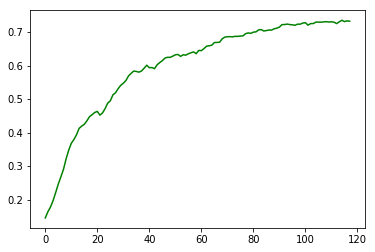

In [122]:
plt.plot(acc_vector, 'g-')
plt.show()

In [ ]:
results_formated = []

with tf.Session() as sess:
    saver.restore(sess, "model_cnn/model.ckpt")
    results = sess.run(predict_test,
                             feed_dict={
                                 test_x:test_images})
    
    
    results_formated = []
    for result in results:
        if max(result.tolist()) != 1:
            results_formated.append(-1)
        else:
            results_formated.append(result.tolist().index(1))

    print("Model restored.")
    print("COMPARE:")
    print("PREDICT: %s"%results_formated[:15])
    print("READ:    %s"%test_labels[:15].tolist())
    

In [49]:
metrics.classification.accuracy_score(test_labels.tolist(),results_formated)

0.5362